# Boilerplate

Algo que pasa es que creemos que algo va a servir para predecir y nos mandamos de lleno a eso y dsps vemos que falla. Uno puede pensar que el elenco es bueno para predecir (va a agregar mucha info) el raiting de una peli, pero vamos a ver si posta es asi. Juntemos evidencia de que el paso que vamos a dar tiene sentida. Evidencia a favor de que tener en cuenta a los actores va a andar bien para predecir el raiting.  

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Si hay cambios en el repositorio, con esta linea actualizas tu drive
!cd /content/gdrive/My\ Drive/ml-practico/code; git pull

In [16]:
import sys
sys.path.append('/content/gdrive/MyDrive/ml-practico/data')

In [ ]:
#import sys
# Para trabajar local
#sys.path.append('/Users/przivic/prog/machine_learning_practico')

In [17]:
from lib import data

In [18]:

from pathlib import Path
import pandas as pd

PATH = Path('/content/gdrive/MyDrive/ml-practico/data/')
ratings_df = data.load_title_ratings(PATH)
basics_df = data.load_title_basics(PATH)
principals_df = pd.read_csv(PATH / 'title.principals.tsv', sep='\t')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Recordemos como era la data

In [19]:
principals_df.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [ ]:
principals_df.category.value_counts()

actor                  9428011
actress                7087536
self                   6992466
writer                 5443248
director               4739306
producer               2533985
cinematographer        1472541
composer               1461940
editor                 1375324
production_designer     302528
archive_footage         245691
archive_sound             2605
Name: category, dtype: int64

In [20]:
principals_df[principals_df.tconst == 'tt0120338'] # titanic

,tconst,ordering,nconst,category,job,characters
1025389,tt0120338,10,nm0365239,editor,\N,\N
1025390,tt0120338,1,nm0000138,actor,\N,"[""Jack Dawson""]"
1025391,tt0120338,2,nm0000701,actress,\N,"[""Rose Dewitt Bukater""]"
1025392,tt0120338,3,nm0000708,actor,\N,"[""Cal Hockley""]"
1025393,tt0120338,4,nm0000870,actress,\N,"[""Molly Brown""]"
1025394,tt0120338,5,nm0000116,director,\N,\N
1025395,tt0120338,6,nm0484457,producer,producer,\N
1025396,tt0120338,7,nm0000035,composer,\N,\N
1025397,tt0120338,8,nm0005665,cinematographer,director of photography,\N
1025398,tt0120338,9,nm0119322,editor,\N,\N


**Dentro del submundo de actores el ordening dice algo. El 1 es dicaprio, el 4 es molly que es alguien secundario.**

## Distribución de cantidad de peliculas por nconst

In [21]:
basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,[Romance]
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897.0,\N,20.0,"[Documentary, News, Sport]"
498,tt0000502,movie,Bohemios,Bohemios,0,1905.0,\N,100.0,[no-genre]
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,\N,70.0,"[Biography, Crime, Drama]"
672,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908.0,\N,120.0,"[Adventure, Fantasy]"


In [22]:
# Nos vamos a quedar solo con principals de las peliculas que nos interesan
# Posiblemente de cosas diferentes, me quedo solo con los actores que actuaron en peliculas, no si actuaron solo en series, etc 
movie_principals_df = principals_df[principals_df.tconst.isin(set(basics_df.tconst.unique()))]

In [23]:
len(movie_principals_df) / len(principals_df)

0.10394285472418875

### Distribucion de cantidad de peliculas por persona

Text(0.5, 1.0, 'Number of films per person')

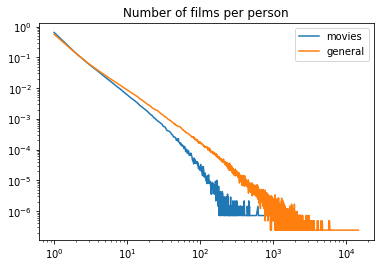

In [24]:
import matplotlib.pyplot as plt

(
    movie_principals_df
        .nconst
        .value_counts()
        .value_counts(normalize=True)
        .sort_index()
        .plot(logx=True, logy=True, label='movies')
)
(
    principals_df
        .nconst
        .value_counts()
        .value_counts(normalize=True)
        .sort_index()
        .plot(logx=True, logy=True, label='general')
)

plt.legend(loc='best')
plt.title('Number of films per person')

Eje x es cantidad de peliculas. Eje y es cantidad de personas (% de gente). Casi el 100% hizo 1=10^0 pelicula. Esta en escala logaritmica porque sino es imposible de leer, se me va de escala.  Las conclusiones de esto podian cambiar si no descartabamos a la gente que actuo solo en series. En general (naranja) tiene una cola mucho mas pesada que solo peliculas (azul).

### Relación con ratings

Experimento: vamos a ver ejemplos claros

**quiero ver si saber que actuo tal persona en una pelicula me da informacion sobre el raiting de la pelicula.**

In [26]:
movie_principals_df = movie_principals_df.merge(ratings_df, on='tconst')

In [27]:
movie_principals_df.head()

,tconst,ordering,nconst,category,job,characters,averageRating,numVotes
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",5.9,154
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",5.9,154
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",5.9,154
3,tt0000009,4,nm0085156,director,\N,\N,5.9,154
4,tt0000147,1,nm0179163,self,\N,"[""Self""]",5.2,356


In [28]:
person_metadata = (
    movie_principals_df[movie_principals_df.numVotes > 1000] # pelis q tengan x lo - 1000 votos
        .groupby('nconst') # agrupo por persona
        .agg(
            n_films=('tconst', 'count'), # cantidad total de pelis en la q actuo la persona
            avg_rating=('averageRating', 'mean'), #el raiting promedio de esas pelis
            max_rating=('averageRating', 'max'), 
            min_rating=('averageRating', 'min'),
    )
)

In [29]:
cohort = (person_metadata.n_films > 10) & (person_metadata.n_films < 30) # personas que tienen entre 10 y 30 peliculas

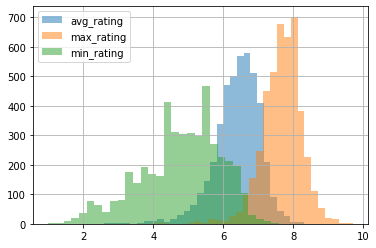

In [30]:
person_metadata[cohort].avg_rating.hist(bins=30, alpha=0.5, label='avg_rating')
person_metadata[cohort].max_rating.hist(bins=30, alpha=0.5, label='max_rating')
person_metadata[cohort].min_rating.hist(bins=30, alpha=0.5, label='min_rating')

plt.legend(loc='best')

Se ve una distribucion del maximo que es mas grande que el minimo y el promedio. Hay gente con entre 10 a 30 pelis y con promedio 9 (la cola derecha de la distribucion del maximo). A eso le confio. Hay gente que sistematicamente hace pelis buenas. Lo mismo con gente que hace sistematicamente pelis malas (cola izquierda de la distribucion verde).

# Parece haber señal, veamos ejemplos puntuales

In [31]:
person_metadata['link'] = (
    person_metadata.index.to_series().apply(lambda nconst: f'<a href="https://www.imdb.com/name/{nconst}">link</a>')
) # el link a su IMDb

In [32]:
person_metadata.head()

,n_films,avg_rating,max_rating,min_rating,link
nconst,,,,,
nm0000001,31,7.045161,7.7,5.8,"<a href=""https://www.imdb.com/name/nm0000001"">..."
nm0000002,27,6.837037,8.0,5.4,"<a href=""https://www.imdb.com/name/nm0000002"">..."
nm0000003,12,6.691667,7.6,5.3,"<a href=""https://www.imdb.com/name/nm0000003"">..."
nm0000004,6,6.533333,7.9,5.6,"<a href=""https://www.imdb.com/name/nm0000004"">..."
nm0000005,45,7.413333,8.5,5.6,"<a href=""https://www.imdb.com/name/nm0000005"">..."


In [33]:
from IPython.display import HTML

df = person_metadata[cohort].sort_values('min_rating', ascending=False)[:100].sample(10)
HTML(
    person_metadata[cohort]
        .sort_values('min_rating', ascending=False)[:100]
        .sample(10)
        .to_html(escape=False)
) # las personas con mejor min rating (con el min raiting mas alto)

,n_films,avg_rating,max_rating,min_rating,link
nconst,,,,,
nm0736778,11,7.163636,7.6,6.7,link
nm0799550,15,7.960000,9.0,7.2,link
nm0950150,13,7.138462,7.8,6.8,link
nm0000036,18,7.472222,8.2,6.7,link
nm0232196,11,7.245455,7.9,6.8,link
nm0005713,12,7.183333,7.8,6.6,link
nm0950707,13,7.184615,7.5,6.6,link
nm0359734,13,7.223077,7.9,6.6,link
nm0027572,11,7.563636,8.1,7.0,link


#### Hay mucha gente de principios del siglo 20. Vamos a filtrar por peliculas mas actuales

In [34]:
movie_principals_df = movie_principals_df.merge(basics_df, on='tconst')

In [43]:
movie_principals_df.head()

,tconst,ordering,nconst,category,job,characters,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",5.9,154,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,[Romance]
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",5.9,154,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,[Romance]
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",5.9,154,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,[Romance]
3,tt0000009,4,nm0085156,director,\N,\N,5.9,154,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,[Romance]
4,tt0000147,1,nm0179163,self,\N,"[""Self""]",5.2,356,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897.0,\N,20.0,"[Documentary, News, Sport]"


In [41]:
person_metadata = (
    movie_principals_df[(movie_principals_df.numVotes > 1000) & (movie_principals_df.startYear > 1970)]
        .groupby('nconst')
        .agg(
            n_films=('tconst', 'count'), 
            avg_rating=('averageRating', 'mean'),
            max_rating=('averageRating', 'max'),
            min_rating=('averageRating', 'min'),
    )
)

In [42]:
cohort = (person_metadata.n_films > 10) & (person_metadata.n_films < 30)

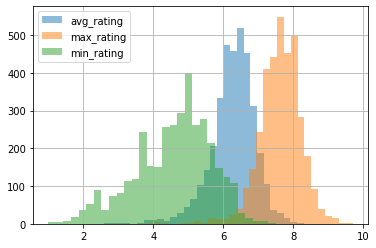

In [44]:
person_metadata[cohort].avg_rating.hist(bins=30, alpha=0.5, label='avg_rating')
person_metadata[cohort].max_rating.hist(bins=30, alpha=0.5, label='max_rating')
person_metadata[cohort].min_rating.hist(bins=30, alpha=0.5, label='min_rating')

plt.legend(loc='best')

In [45]:
person_metadata['link'] = (
    person_metadata.index.to_series().apply(lambda nconst: f'<a href="https://www.imdb.com/name/{nconst}">link</a>')
)

In [46]:
df = person_metadata[cohort].sort_values('min_rating', ascending=False)[:100].sample(10)
HTML(
    person_metadata[cohort]
        .sort_values('min_rating', ascending=False)[:100]
        .sample(10)
        .to_html(escape=False)
)

,n_films,avg_rating,max_rating,min_rating,link
nconst,,,,,
nm1940449,12,7.141667,8.1,6.5,link
nm0837675,11,7.772727,8.4,7.1,link
nm0802846,12,7.308333,8.1,6.4,link
nm2953454,11,7.909091,8.6,6.9,link
nm0394690,12,7.291667,7.9,6.5,link
nm0462232,14,7.342857,8.3,6.6,link
nm0002191,13,7.092308,7.9,6.3,link
nm1321655,12,7.133333,8.4,6.3,link
nm1321656,12,7.133333,8.4,6.3,link
